## Proyecto monitoreo Bancolombia -- Reporte semanal


In [7]:


from tkinter import Variable
import requests
import pandas as pd
import json
import time
from datetime import datetime
from matplotlib import pyplot as plt

import os
from dotenv import dotenv_values
config = dotenv_values(".env")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


class Ubidots:

    def sendDatatoUbidots(pload, headers, request):
        r = requests.post(request,headers=headers, json=pload)

        if  200 <= r.status_code <= 299:
            print("Sent",r.text,"with response code: ",r.status_code)

        if  400 <= r.status_code <= 499:
            print("Retrying...", r.text)
            time.sleep(5)
                
        time.sleep(1)

        return r.text


    def makeUbidotsPayload(value,timestamp,timestampformat):

        pload = { "value": value,
                "timestamp": str(int(datetime.timestamp(datetime.strptime(timestamp,timestampformat))))+'000'}
        return pload


    def makeUbidotsRequest(device_id,variable_id):

        request = 'https://industrial.api.ubidots.com/api/v1.6/devices/'+device_id+'/'+variable_id+'/values'+'/?force=true'

        return request



    def makeUbidotsHeaders(TOKEN):

        headers = {'X-Auth-Token':TOKEN, 'Content-Type':'application/json'}

        return headers

    def Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, TOKEN):
        try:
            datarange_object =  {'start' : int(datetime.timestamp(datetime.strptime(datarange['start'] + 'T00:00:00',timestamp_format))), 'end' : int(datetime.timestamp(datetime.strptime(datarange['end'] + 'T00:00:00',timestamp_format)))}


            pload = {'token': token}

            r = requests.get('https://industrial.api.ubidots.com/api/v1.6/devices/' + device_label + '/' + variable_label + '/values?page_size=1?&start=' + str(datarange_object['start'])+'000'+'&end='+str(datarange_object['end']) + '000', params = pload)

            df = pd.json_normalize(r.json(), record_path =['results'])

            timestamps = df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
            df.set_index('timestamp', inplace=True)
            df["created_at"] = pd.to_datetime(df["created_at"], unit='ms')
            df.drop(['created_at'], axis=1, inplace=True)
            df = df.reindex(index=df.index[::-1])

            
            
        except: 
            pass

        return df.rename(columns={"value": variable_label})

        

    
    def get_device_group_devices(token, device_group_label):
        
        pload = {'token':token}
        r = requests.get('https://industrial.api.ubidots.com/api/v2.0/device_groups/'+device_group_label+'/devices/?token='+token, params=pload)

        r.text
        JSON = r.json()

        devices = {
            "device_name" : [],
            "id" : [],
            "label" : []
            }

        for JSON_item in JSON['results']:
            devices["device_name"].append(JSON_item['name'])
            devices["id"].append(JSON_item['id'])
            devices["label"].append(JSON_item['label'])

        return devices

    
    def get_concatenated_dataframe_multiple_devices(df,device_group_devices, variable_label,datarange, timestamp_format, token):
        for i in range(1,len(device_group_devices["device_name"])):
            device_label = device_group_devices["label"][i]
            req_data =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)        
            df = df.merge(req_data,  how='outer')
        return df

    
    def get_all_variables_from_device(token, device_key):
        
        pload = {'token':token}
        r = requests.get('https://industrial.api.ubidots.com/api/v2.0/devices/'+device_key+'/variables/?token='+token, params=pload)

        r.text
        JSON = r.json()

        variables = {
            "variable_name" : [],
            "variable_id" : [],
            "variable_label" : []
            }

        for JSON_item in JSON['results']:
            variables["variable_name"].append(JSON_item['name'])
            variables["variable_id"].append(JSON_item['id'])
            variables["variable_label"].append(JSON_item['label'])

        return variables


    def get_concatenated_dataframe_from_device(df,variables, device_label,datarange,variables_to_download, timestamp_format, token):
            for i in range(1,len(variables["variable_name"])):

                variable_label = variables["variable_label"][i]

                if variable_label in variables_to_download:
                    req_data =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)        
                    df = df.merge(req_data, left_on='timestamp', right_on='timestamp', how='left')
                    
            return df



In [8]:
token = config["token"]
device_group_label = '61cb3d7eb154cc2dd4a72192'
datarange = { 'start': '2022-06-19',
            'end': '2022-06-26'}
timestamp_format = "%Y-%m-%dT%H:%M:%S"

devices = Ubidots.get_device_group_devices(token, device_group_label)


AttributeError: 'collections.OrderedDict' object has no attribute 'token'

## Sedes disponibles

In [6]:

print("El rango de visualización de este informe es desde: ", datarange['start'], " hasta: ", datarange['end'])
print("")
devices["device_name"]

El rango de visualización de este informe es desde:  2022-06-19  hasta:  2022-06-26



['BC 291 - Las Palmas',
 'BC 90 - Megamall',
 'BC 799 - Floridablanca',
 'BC 749 - Santa Monica',
 'BC 66 - Palmira',
 'BC 205 - Villa Colombia',
 'BC 424 - Honda',
 'BC 863 - Los Patios',
 'BC 834 - San Mateo',
 'BC 044 - Piedecuesta',
 'BC 776 - Lebrija',
 'BC 792 - Paseo del comercio',
 'BC 824 - Ventura Plaza',
 'BC 459 - Campo Alegre',
 'BC 306 - Barrancabermeja',
 'BC 311 - Bello',
 'BC 185 - Llano Grande Palmira',
 'BC 88 - Cúcuta',
 'BC 197 - Guatapuri',
 'BC 78 - El Cacique',
 'BC 659 - Girardot']

## BC 291 - Las Palmas

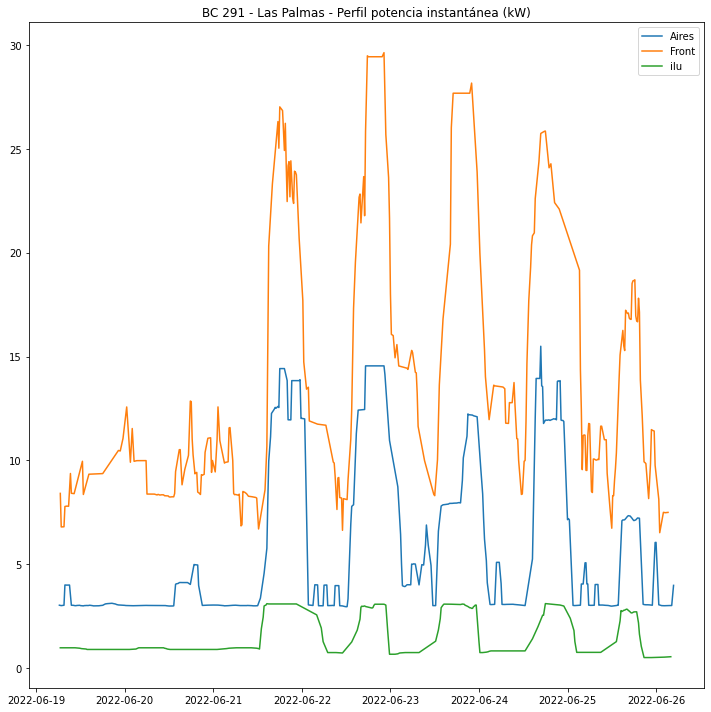

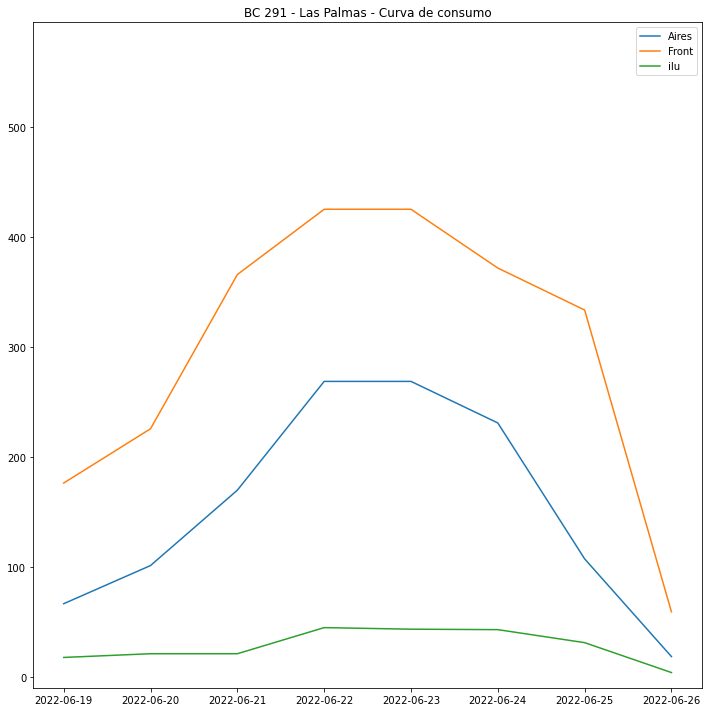

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       176.19        66.460         17.600          92.130  
2022-06-20 00:00:00       225.52       101.160         20.980         103.380  
2022-06-21 00:00:00       365.74       169.680         20.980         175.080  
2022-06-22 00:00:00       425.10       268.590         44.720         111.790  
2022-06-23 00:00:00       425.10       268.590         43.290         113.220  
2022-06-24 00:00:00       371.66       230.800         42.880          97.980  
2022-06-25 00:00:00       333.48       107.240         31.050         195.190  
2022-06-26 00:00:00        59.02        18.380          3.860          36.780  
Total                    2381.81      1230.900        225.360         925.550  
%                         100.00        51.679          9.462          38.859  


In [7]:


device_label = devices["label"][0]
device_name = devices["device_name"][0]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Manejo adecuado de las luces durante fin de semana
* Consumo constante de energía en circuito de Aires durante fin de semana ~ 12 kWh con pico durante una hora aproximadamente el lunes 20 de junio
* Se visualizan consumos anómalos de energía asociados a pérdida de datos en el sistema de monitoreo

## BC 90 - Megamall

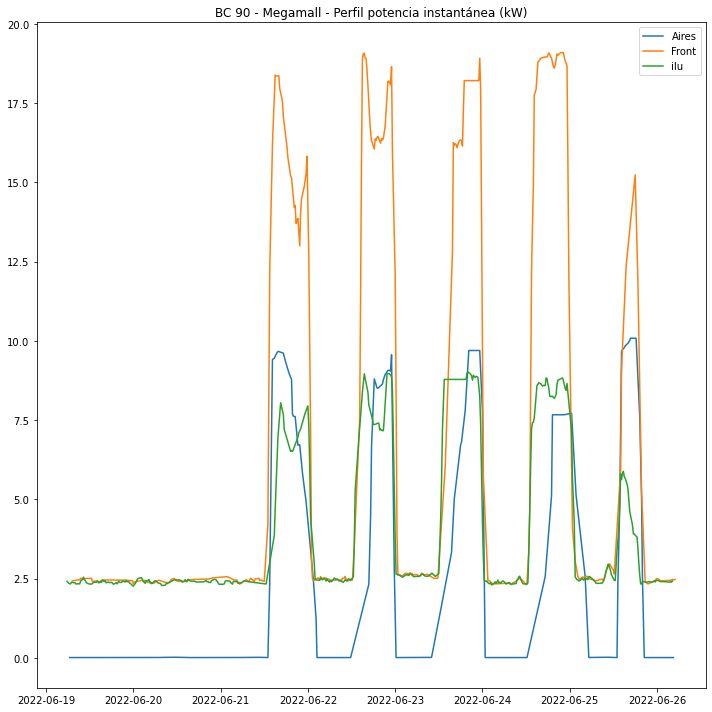

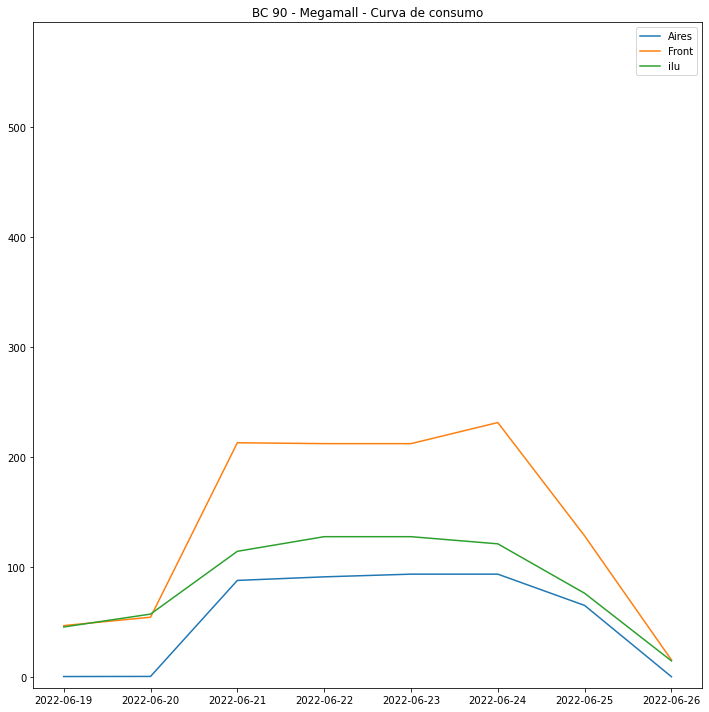

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        46.55         0.240         45.300          1.010   
2022-06-20 00:00:00        54.18         0.340         57.020         -3.180   
2022-06-21 00:00:00       212.80        87.640        114.100         11.060   
2022-06-22 00:00:00       212.00        90.880        127.400         -6.280   
2022-06-23 00:00:00       212.00        93.330        127.400         -8.730   
2022-06-24 00:00:00       231.17        93.330        120.900         16.940   
2022-06-25 00:00:00       128.11        64.890         75.950        -12.730   
2022-06-26 00:00:00        15.32         0.070         14.480          0.770   
Total                    1112.13       430.720        682.550         -1.140   
%                         100.00        38.729         61.373         -0.103   


In [5]:


device_label = devices["label"][1]
device_name = devices["device_name"][1]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Manejo adecuado de las luces durante fin de semana
* Consumo nocturno asociado casi en su totalidad al circuito de iluminación
* Consumo en circuito de Aire acondicionado durante el Domingo 26 de junio ~ 40 kWh 

## BC 799 - Floridablanca

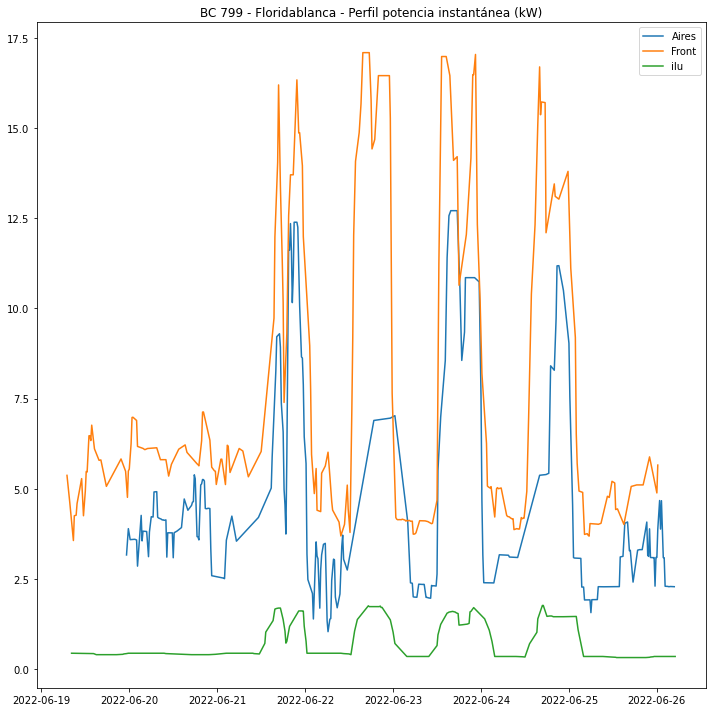

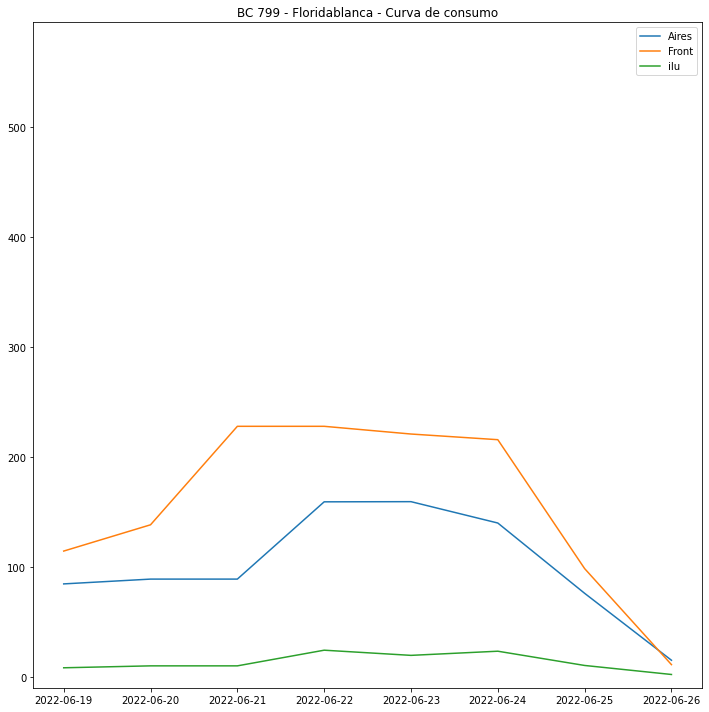

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       114.32        84.470          8.200          21.650  
2022-06-20 00:00:00       138.21        88.830          9.950          39.430  
2022-06-21 00:00:00       227.75        88.830          9.950         128.970  
2022-06-22 00:00:00       227.75       159.090         24.190          44.470  
2022-06-23 00:00:00       220.74       159.240         19.490          42.010  
2022-06-24 00:00:00       215.59       139.820         23.270          52.500  
2022-06-25 00:00:00        98.38        75.910         10.310          12.160  
2022-06-26 00:00:00        11.07        15.050          2.110          -6.090  
Total                    1253.81       811.240        107.470         335.100  
%                         100.00        64.702          8.571          26.727  


In [8]:

device_label = devices["label"][2]
device_name = devices["device_name"][2]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo nocturo del circuito de Aire acondicionado durante el Lunes festivo, 20 de Junio ~ 20 kWh
* Consumo atípico del circuito de aire acondicionado, se continuará monitoreando

## BC 749 - Santa Monica

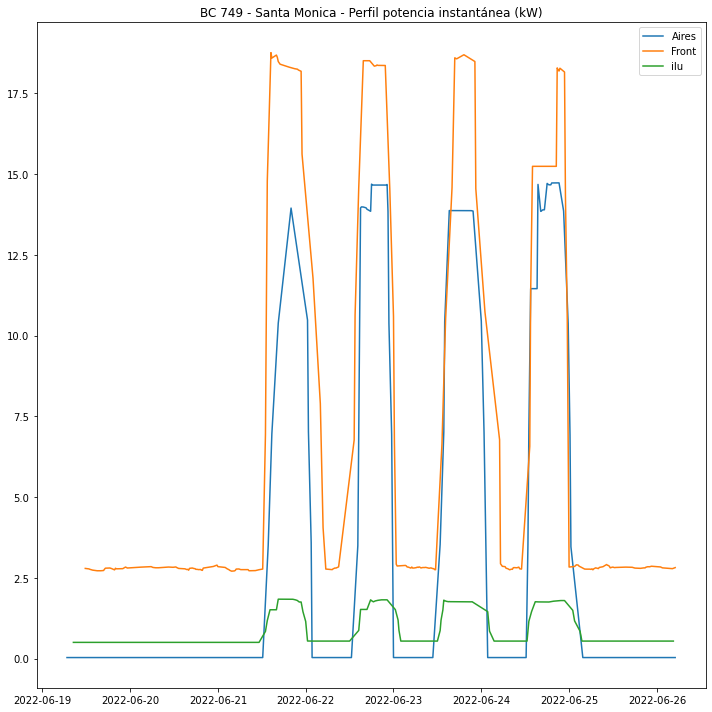

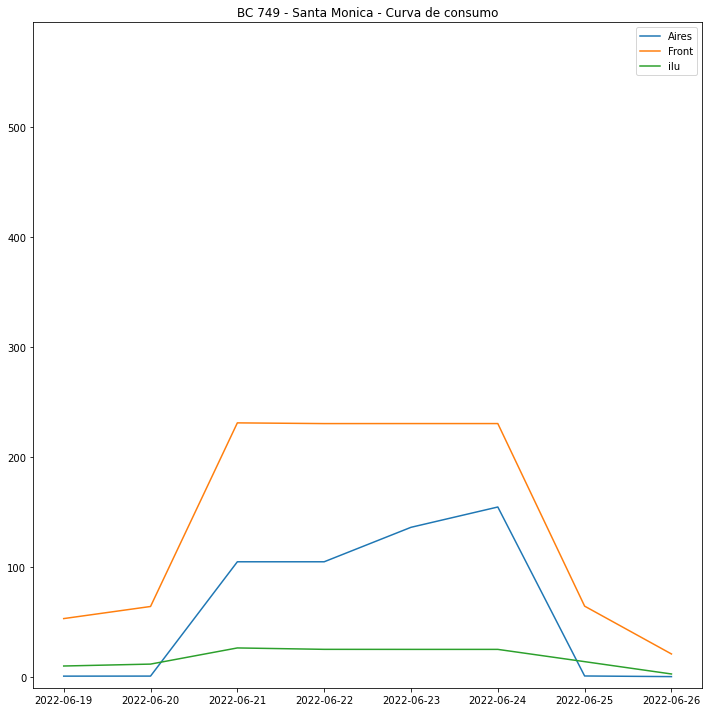

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        52.93         0.600          9.810          42.520  
2022-06-20 00:00:00        63.93         0.640         11.550          51.740  
2022-06-21 00:00:00       230.88       104.580         26.240         100.060  
2022-06-22 00:00:00       230.23       104.580         24.970         100.680  
2022-06-23 00:00:00       230.25       135.920         24.930          69.400  
2022-06-24 00:00:00       230.25       154.380         24.930          50.940  
2022-06-25 00:00:00        64.24         0.750         13.780          49.710  
2022-06-26 00:00:00        20.76         0.170          2.570          18.020  
Total                    1123.47       501.620        138.780         483.070  
%                         100.00        44.649         12.353          42.998  


In [9]:


device_label = devices["label"][3]
device_name = devices["device_name"][3]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Sin hallazgos de relevancia, consumo adecuado en el circuito de Aire acondicionado e Iluminación con consumos residuales ~ 2 kWh posiblemente causados por la presencia de algún cajero o sistemas de seguridad

## BC 66 - Palmira

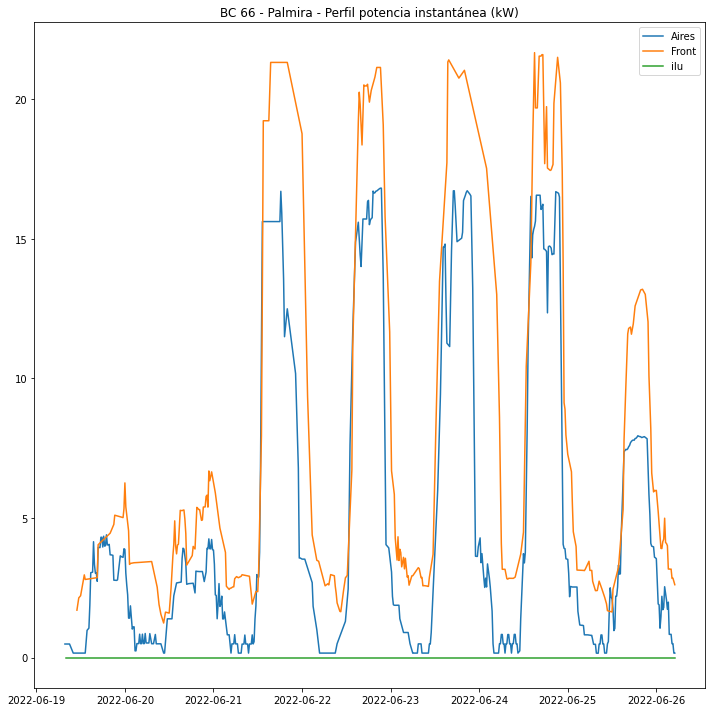

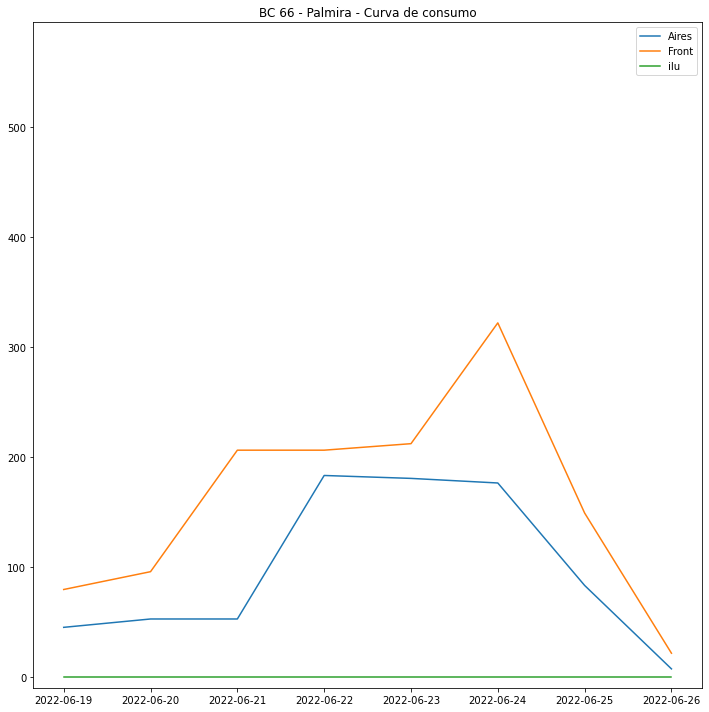

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        79.38        44.970          0.0            34.410  
2022-06-20 00:00:00        95.58        52.570          0.0            43.010  
2022-06-21 00:00:00       206.05        52.570          0.0           153.480  
2022-06-22 00:00:00       206.05       183.050          0.0            23.000  
2022-06-23 00:00:00       211.97       180.400          0.0            31.570  
2022-06-24 00:00:00       321.80       176.220          0.0           145.580  
2022-06-25 00:00:00       148.90        83.070          0.0            65.830  
2022-06-26 00:00:00        21.45         7.200          0.0            14.250  
Total                    1291.18       780.050          0.0           511.130  
%                         100.00        60.414          0.0            39.586  


In [10]:

device_label = devices["label"][4]
device_name = devices["device_name"][4]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo de Aire acondicionado durante fines de semana ~ 12 kWh durante todo el día del Domingo 19 y Lunes 20 de junio


## BC 205 - Villa Colombia

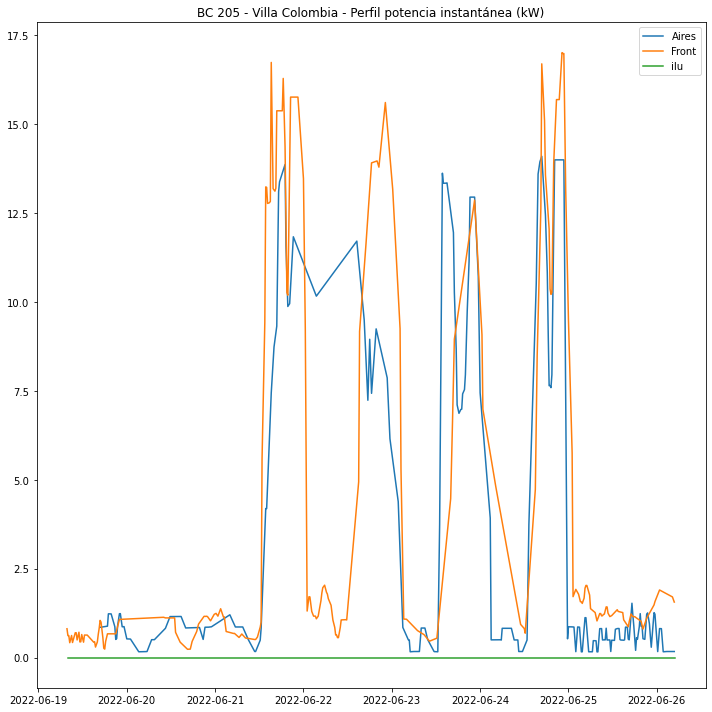

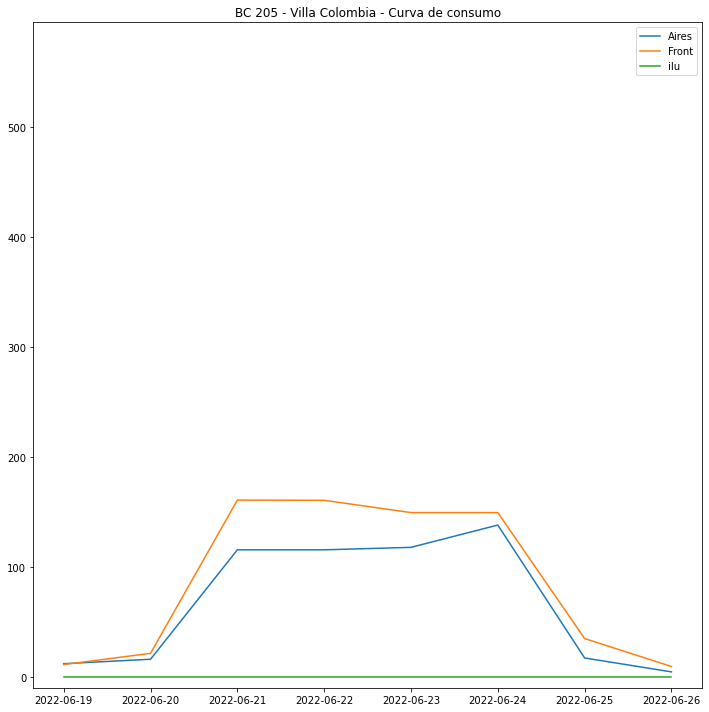

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       11.14         11.91           0.0            -0.77   
2022-06-20 00:00:00       21.34         15.98           0.0             5.36   
2022-06-21 00:00:00      160.66        115.45           0.0            45.21   
2022-06-22 00:00:00      160.48        115.45           0.0            45.03   
2022-06-23 00:00:00      149.30        117.71           0.0            31.59   
2022-06-24 00:00:00      149.30        137.97           0.0            11.33   
2022-06-25 00:00:00       34.78         17.12           0.0            17.66   
2022-06-26 00:00:00        9.36          4.47           0.0             4.89   
Total                    696.36        536.06           0.0           160.30   
%                        100.00         76.98           0.0            23.02   


In [11]:

device_label = devices["label"][5]
device_name = devices["device_name"][5]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo de Aire acondicionado durante periodos nocturnos y fines de semana ~ 4 kWh
* Se presenta una pérdida de datos durante la madrugada del Miércoles 22 de Junio, se seguirá monitoreando

## BC 424 - Honda

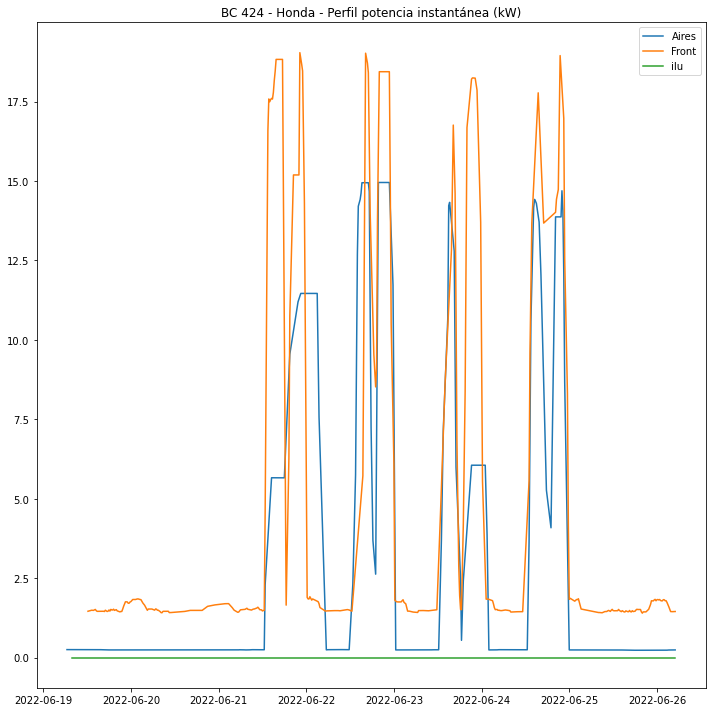

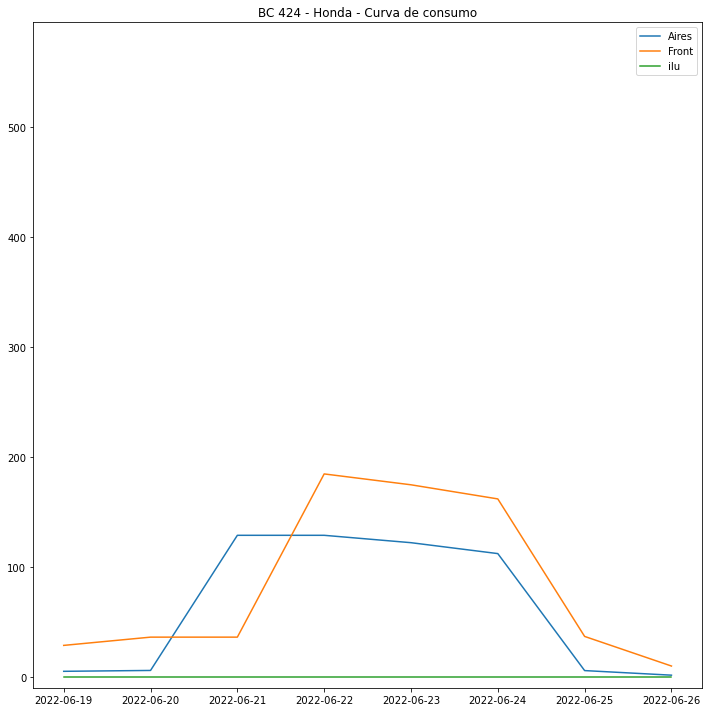

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       28.56          4.990          0.0            23.570  
2022-06-20 00:00:00       36.06          5.780          0.0            30.280  
2022-06-21 00:00:00       36.06        128.650          0.0           -92.590  
2022-06-22 00:00:00      184.46        128.650          0.0            55.810  
2022-06-23 00:00:00      174.58        121.940          0.0            52.640  
2022-06-24 00:00:00      161.74        112.020          0.0            49.720  
2022-06-25 00:00:00       36.71          5.650          0.0            31.060  
2022-06-26 00:00:00        9.79          1.480          0.0             8.310  
Total                    667.96        509.160          0.0           158.800  
%                        100.00         76.226          0.0            23.774  


In [12]:


device_label = devices["label"][6]
device_name = devices["device_name"][6]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Sin hallazgos de relevancia

## BC 863 - Los Patios

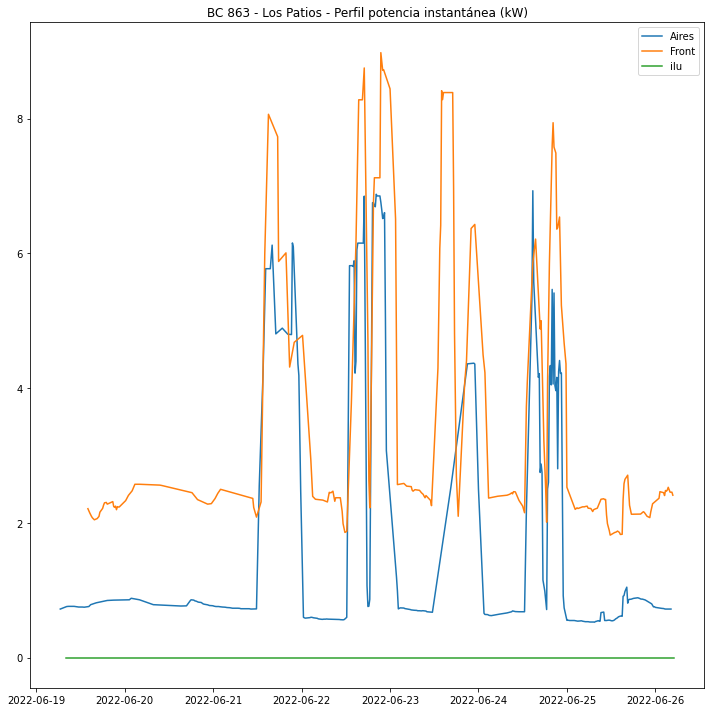

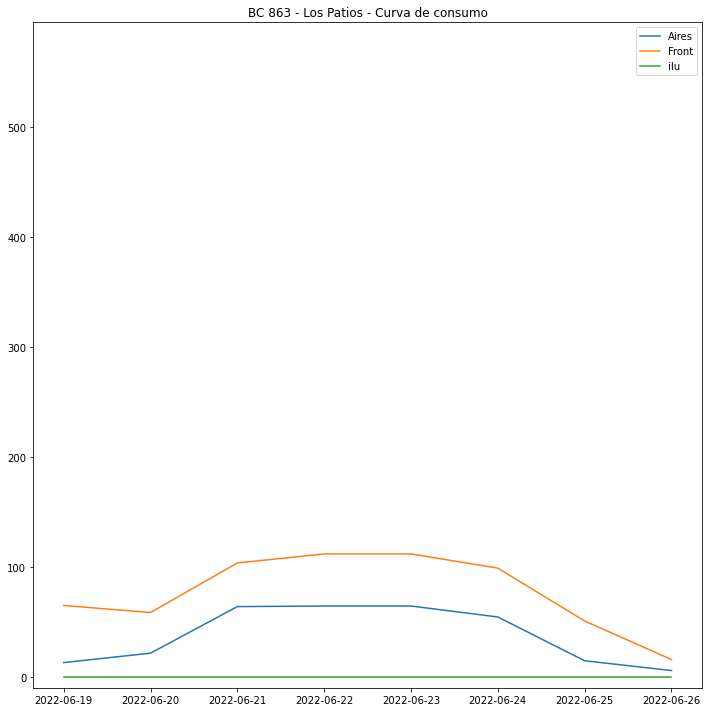

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       64.86         12.94           0.0            51.92   
2022-06-20 00:00:00       58.44         21.48           0.0            36.96   
2022-06-21 00:00:00      103.49         63.83           0.0            39.66   
2022-06-22 00:00:00      111.70         64.35           0.0            47.35   
2022-06-23 00:00:00      111.70         64.35           0.0            47.35   
2022-06-24 00:00:00       98.81         54.40           0.0            44.41   
2022-06-25 00:00:00       50.73         14.58           0.0            36.15   
2022-06-26 00:00:00       15.73          5.71           0.0            10.02   
Total                    615.46        301.64           0.0           313.82   
%                        100.00         49.01           0.0            50.99   


In [13]:


device_label = devices["label"][7]
device_name = devices["device_name"][7]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo residual en circuito de aire acondicionado ~ 4 kWh durante las noches

## BC 834 - San Mateo

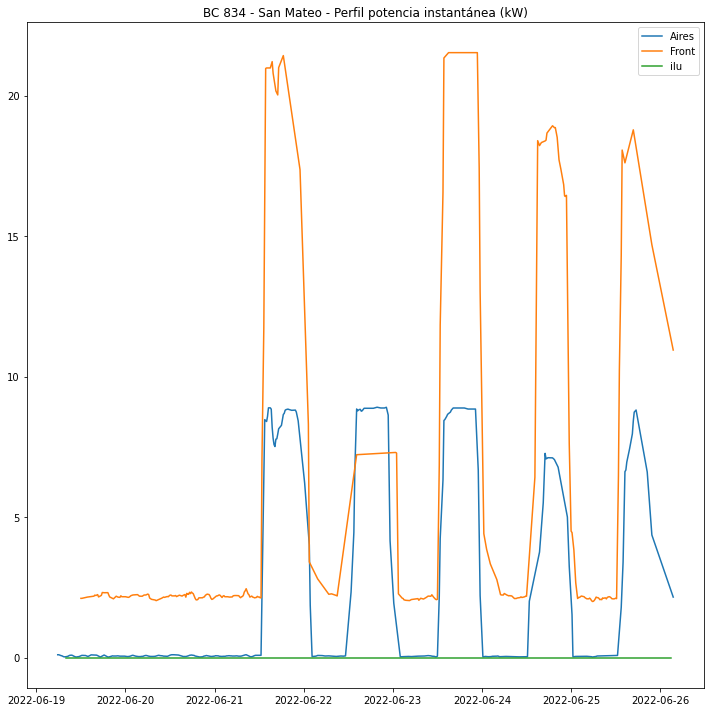

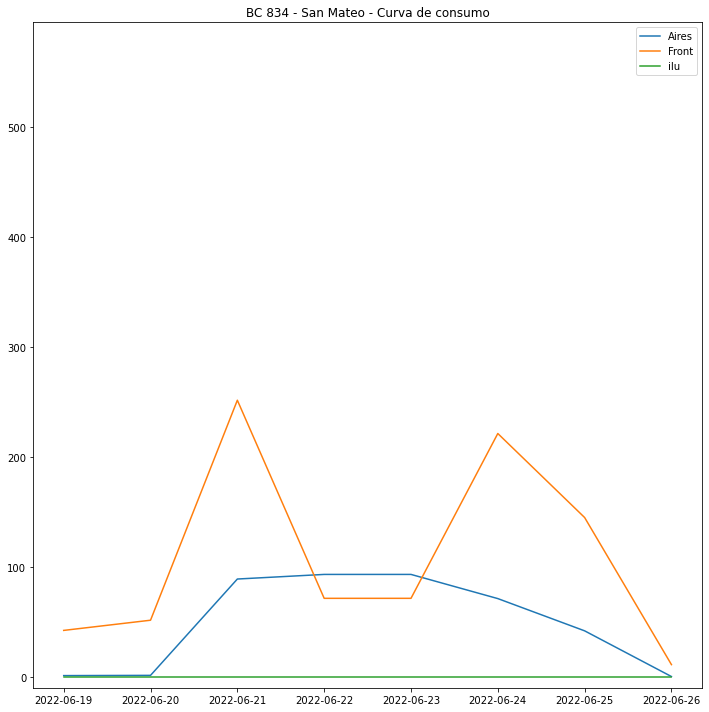

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       42.19          1.090          0.0            41.100  
2022-06-20 00:00:00       51.45          1.310          0.0            50.140  
2022-06-21 00:00:00      251.47         88.900          0.0           162.570  
2022-06-22 00:00:00       71.35         93.090          0.0           -21.740  
2022-06-23 00:00:00       71.35         93.090          0.0           -21.740  
2022-06-24 00:00:00      221.21         71.110          0.0           150.100  
2022-06-25 00:00:00      144.81         41.790          0.0           103.020  
2022-06-26 00:00:00       11.07          0.230          0.0            10.840  
Total                    864.90        390.610          0.0           474.290  
%                        100.00         45.162          0.0            54.838  


In [14]:


device_label = devices["label"][8]
device_name = devices["device_name"][8]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Baja significativa de consumo durante el niércoles 22 de junio, posible pérdida de datos, se seguirá monitoreando

## BC 044 - Piedecuesta

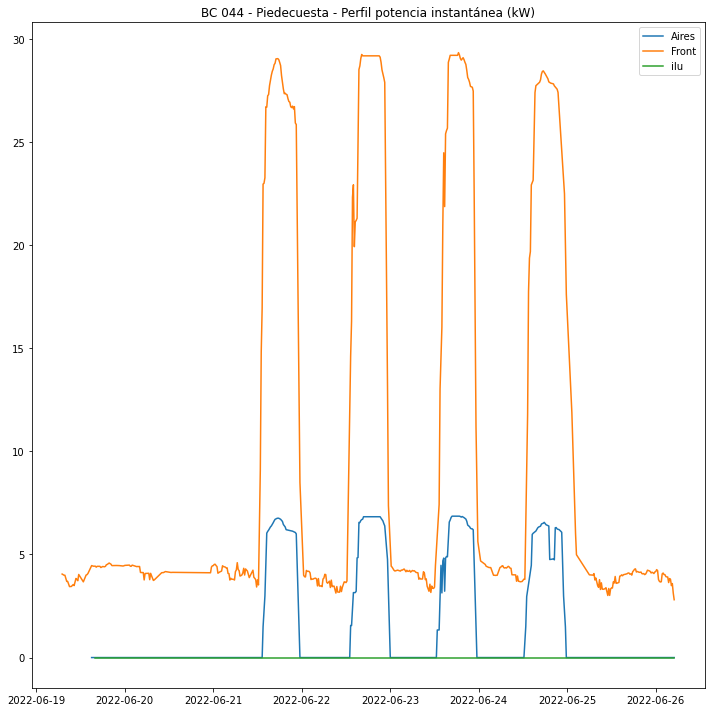

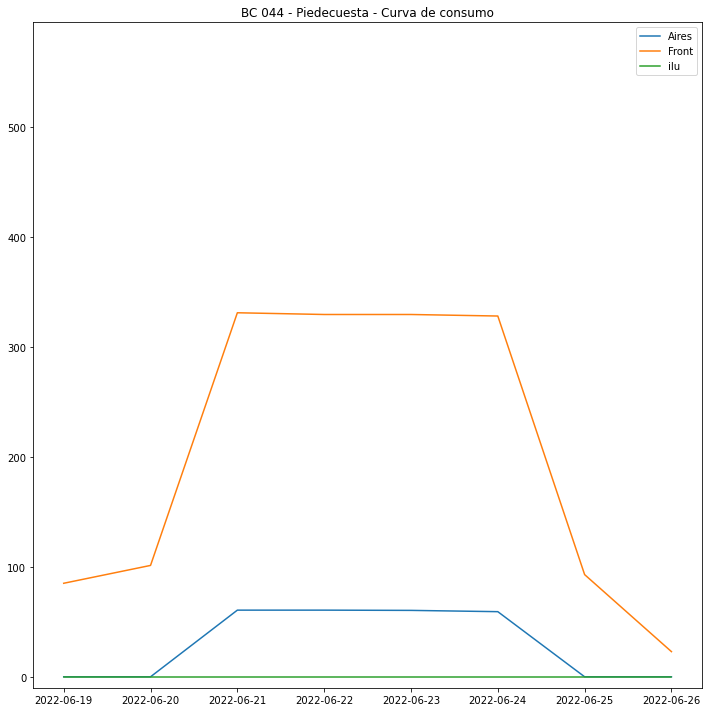

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        85.04         0.000          0.0            85.040  
2022-06-20 00:00:00       101.27         0.000          0.0           101.270  
2022-06-21 00:00:00       330.99        60.610          0.0           270.380  
2022-06-22 00:00:00       329.42        60.610          0.0           268.810  
2022-06-23 00:00:00       329.42        60.390          0.0           269.030  
2022-06-24 00:00:00       328.03        59.220          0.0           268.810  
2022-06-25 00:00:00        92.92         0.000          0.0            92.920  
2022-06-26 00:00:00        22.88         0.000          0.0            22.880  
Total                    1619.97       240.830          0.0          1379.140  
%                         100.00        14.866          0.0            85.134  


In [15]:

device_label = devices["label"][9]
device_name = devices["device_name"][9]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Poca contribución al consumo por parte del circuito de HVAC, menor al 15% del consumo total, se sugiere continuar monitoreando la situación

## BC 776 - Lebrija

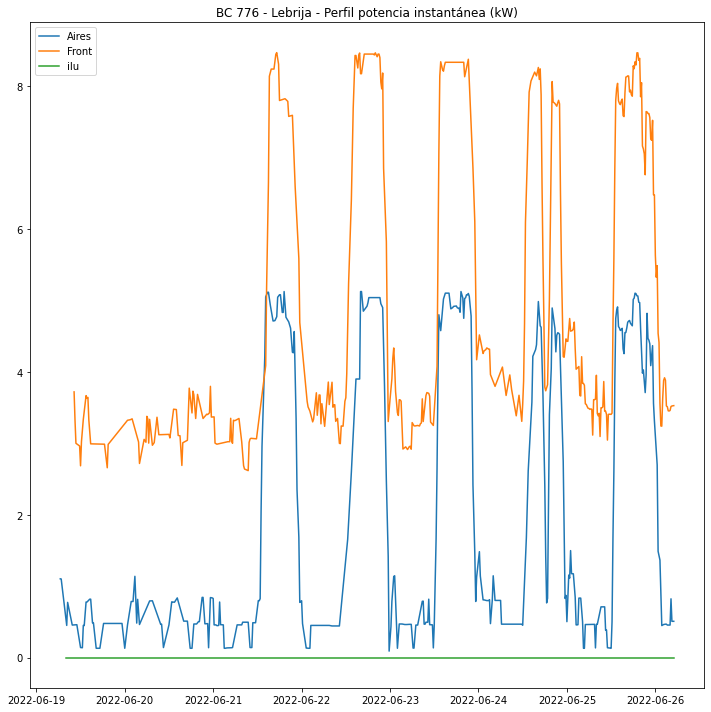

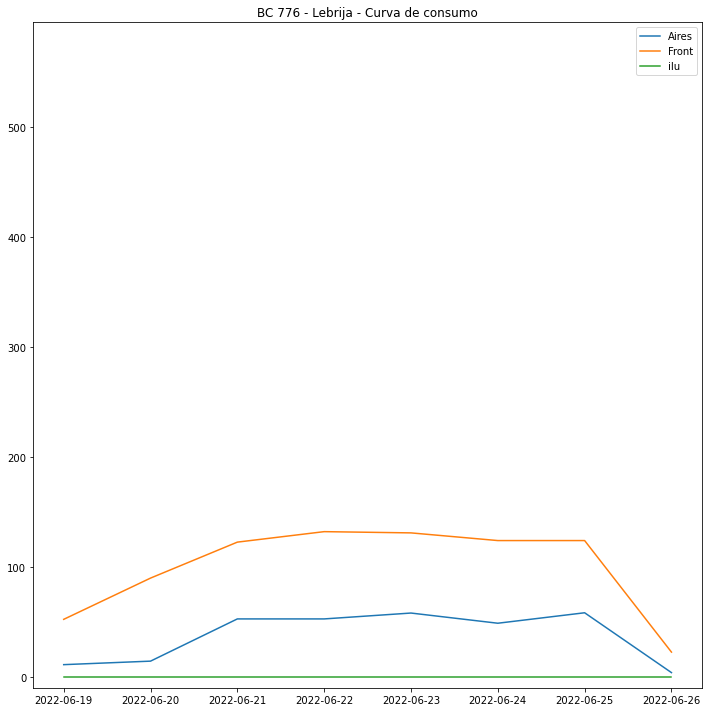

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       52.25         11.050          0.0            41.200  
2022-06-20 00:00:00       89.75         14.240          0.0            75.510  
2022-06-21 00:00:00      122.45         52.630          0.0            69.820  
2022-06-22 00:00:00      131.98         52.630          0.0            79.350  
2022-06-23 00:00:00      130.85         57.970          0.0            72.880  
2022-06-24 00:00:00      123.87         48.710          0.0            75.160  
2022-06-25 00:00:00      123.87         58.220          0.0            65.650  
2022-06-26 00:00:00       22.46          3.810          0.0            18.650  
Total                    797.48        299.260          0.0           498.220  
%                        100.00         37.526          0.0            62.474  


In [16]:

device_label = devices["label"][10]
device_name = devices["device_name"][10]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumos residuales en el circuito de Aire acondicionado ~ 4 kWh durante las noches

## BC 792 - Paseo del comercio

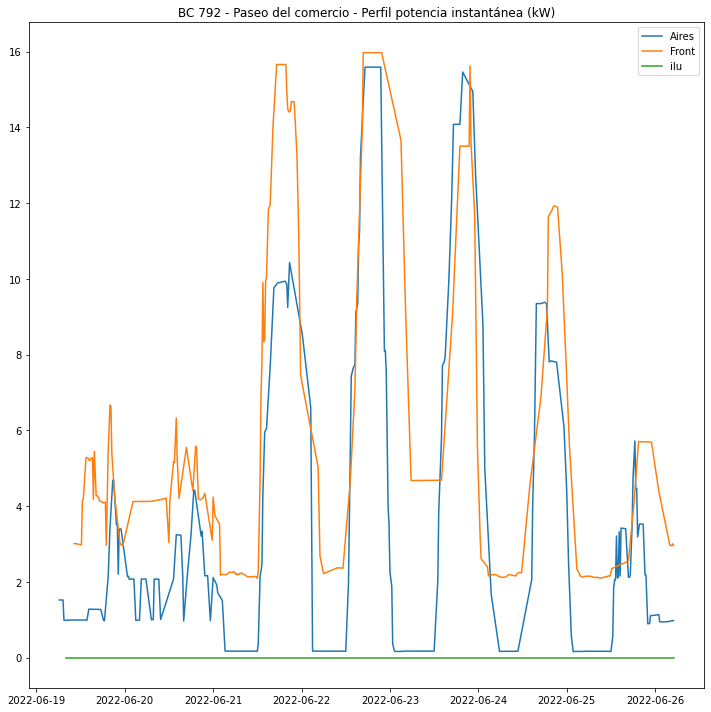

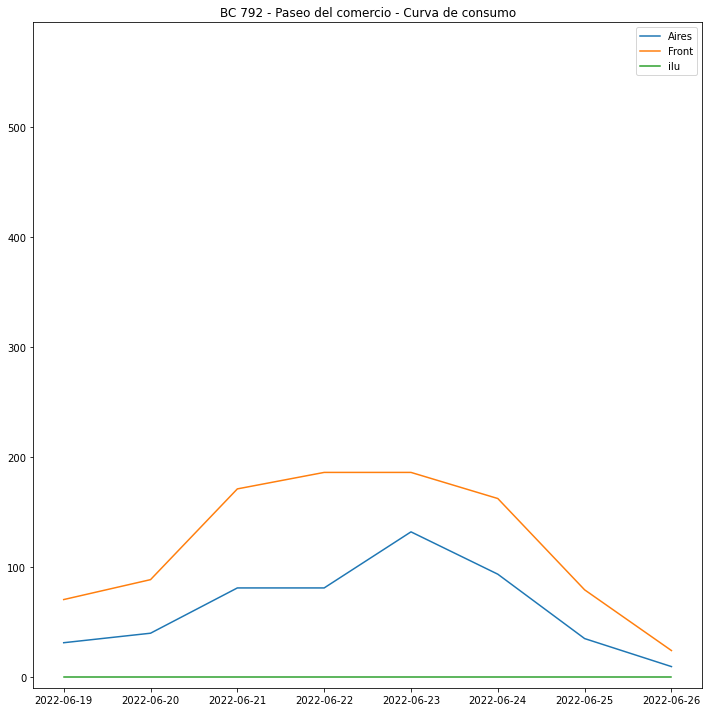

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       70.23         30.990          0.0            39.240  
2022-06-20 00:00:00       88.34         39.630          0.0            48.710  
2022-06-21 00:00:00      170.85         80.800          0.0            90.050  
2022-06-22 00:00:00      185.84         80.800          0.0           105.040  
2022-06-23 00:00:00      185.84        131.790          0.0            54.050  
2022-06-24 00:00:00      162.09         93.290          0.0            68.800  
2022-06-25 00:00:00       79.07         34.750          0.0            44.320  
2022-06-26 00:00:00       23.86          9.290          0.0            14.570  
Total                    966.12        501.340          0.0           464.780  
%                        100.00         51.892          0.0            48.108  


In [17]:

device_label = devices["label"][11]
device_name = devices["device_name"][11]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo de energía durante los fines de semana, 19 y 20 de Junio ~ 35 kWh, 25 de junio ~ 35kWh, 26 de junio ~ 10kWh. Se sugiere validar si existe alguna carga parasitiva que explique este comportamiento.

## BC 824 - Ventura Plaza

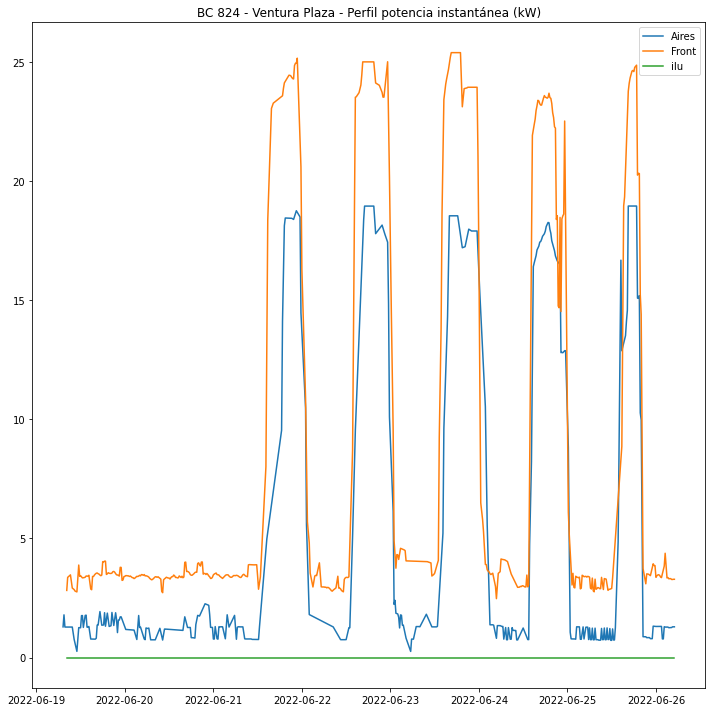

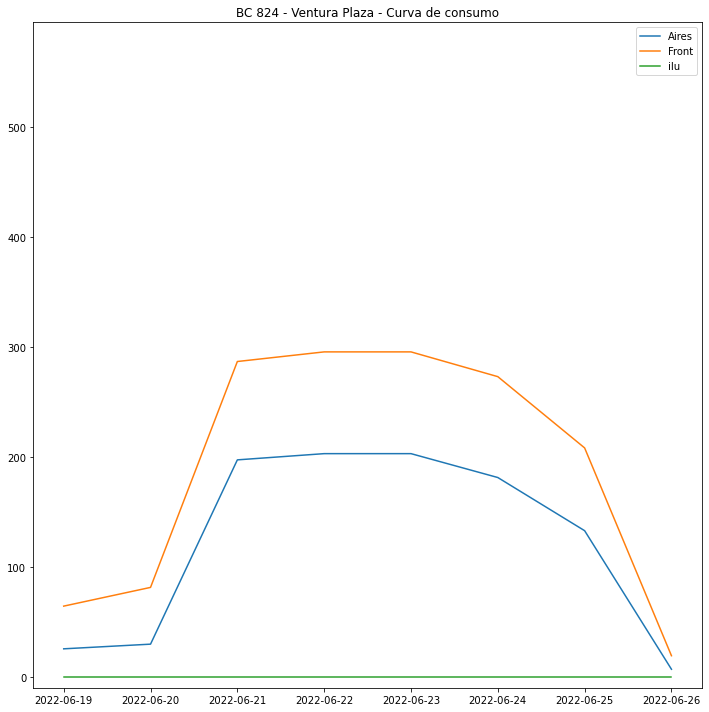

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        64.26        25.440          0.0            38.820  
2022-06-20 00:00:00        81.29        29.680          0.0            51.610  
2022-06-21 00:00:00       286.67       197.240          0.0            89.430  
2022-06-22 00:00:00       295.42       202.900          0.0            92.520  
2022-06-23 00:00:00       295.42       202.900          0.0            92.520  
2022-06-24 00:00:00       272.91       181.190          0.0            91.720  
2022-06-25 00:00:00       208.10       132.840          0.0            75.260  
2022-06-26 00:00:00        19.17         6.870          0.0            12.300  
Total                    1523.24       979.060          0.0           544.180  
%                         100.00        64.275          0.0            35.725  


In [18]:

device_label = devices["label"][12]
device_name = devices["device_name"][12]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Sin hallazgos de relevancia, consumos nocturnos durante las noches y fines de semana ~ 25 kWh durante el fin de semana del 19 /   20 de junio, ~ 7 kWh durante el 26 de junio

## BC 459 - Campo Alegre

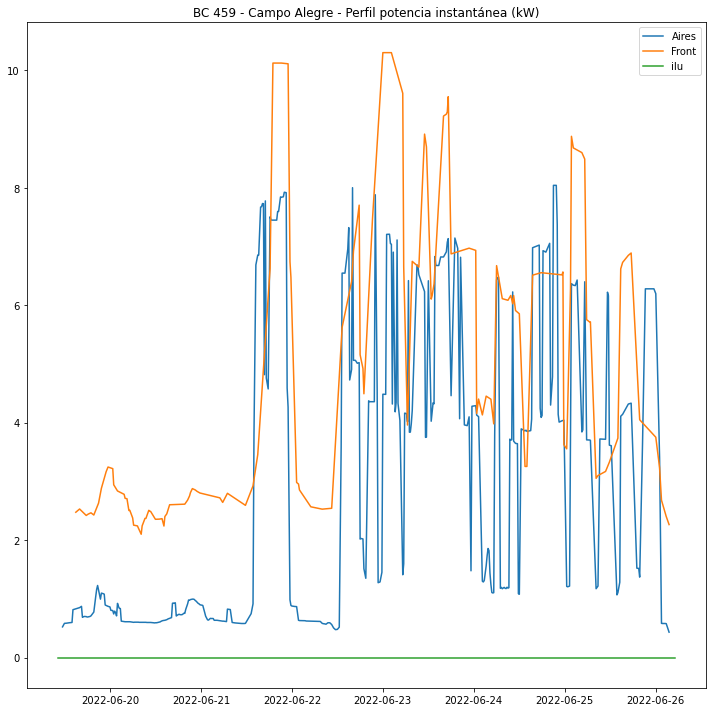

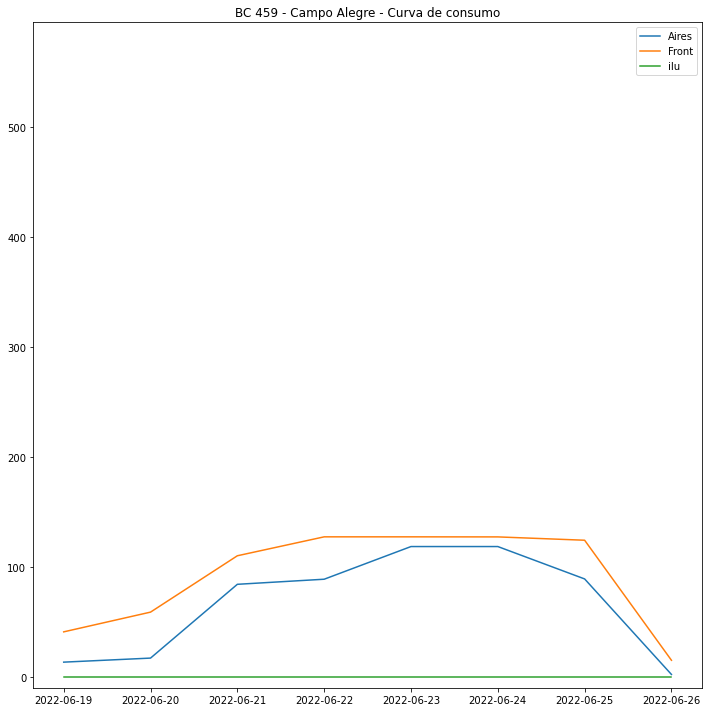

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       40.87         13.330          0.0            27.540  
2022-06-20 00:00:00       58.81         17.010          0.0            41.800  
2022-06-21 00:00:00      110.05         84.100          0.0            25.950  
2022-06-22 00:00:00      127.26         88.720          0.0            38.540  
2022-06-23 00:00:00      127.26        118.430          0.0             8.830  
2022-06-24 00:00:00      127.20        118.430          0.0             8.770  
2022-06-25 00:00:00      124.17         88.980          0.0            35.190  
2022-06-26 00:00:00       15.02          2.130          0.0            12.890  
Total                    730.64        531.130          0.0           199.510  
%                        100.00         72.694          0.0            27.306  


In [19]:


device_label = devices["label"][13]
device_name = devices["device_name"][13]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumos erraticos del aire acondicionado durante todo el periodo monitoreado a excepción de los fines de semana, se sugiere validar si existe alguna carga adicional al aire acondicionado que explique este comportamiento.

## BC 306 - Barrancabermeja

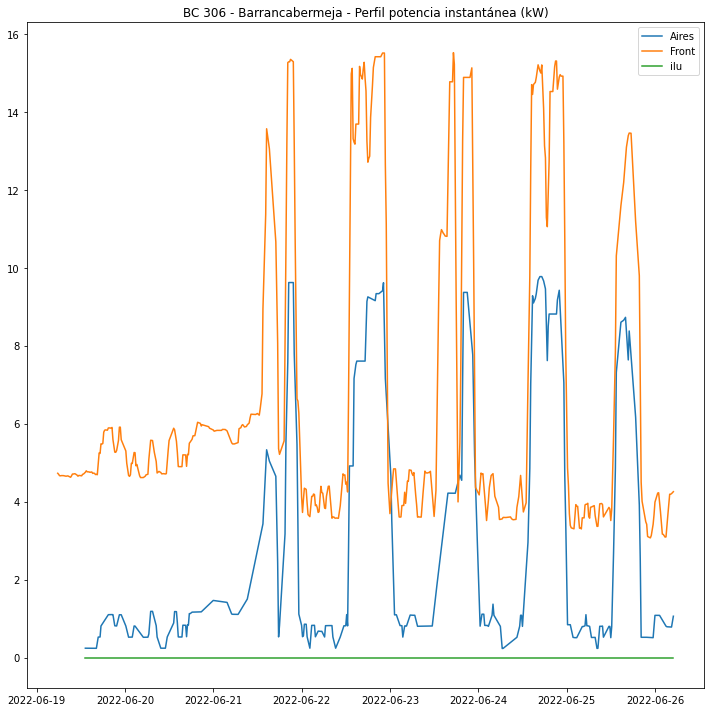

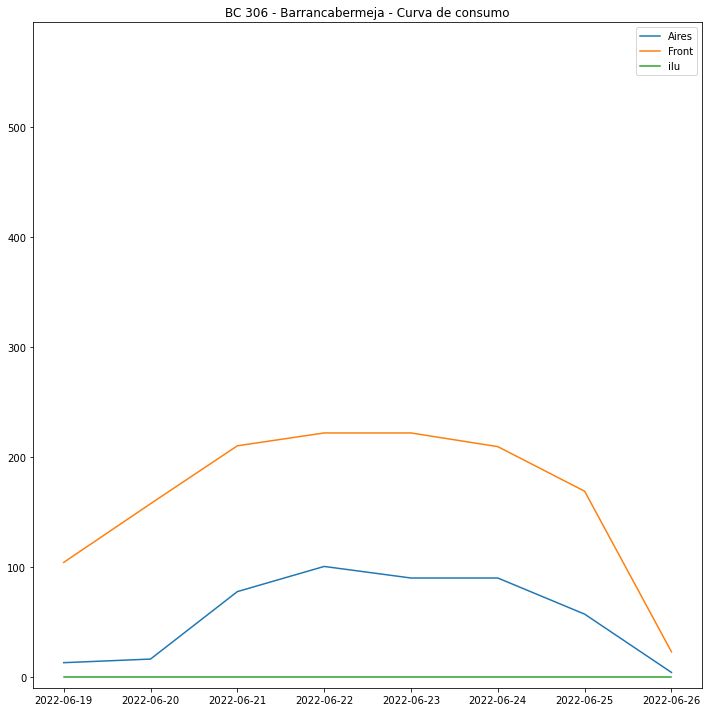

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       104.03        12.840          0.0            91.190  
2022-06-20 00:00:00       157.37        16.120          0.0           141.250  
2022-06-21 00:00:00       210.03        77.460          0.0           132.570  
2022-06-22 00:00:00       221.71       100.340          0.0           121.370  
2022-06-23 00:00:00       221.71        89.820          0.0           131.890  
2022-06-24 00:00:00       209.27        89.820          0.0           119.450  
2022-06-25 00:00:00       168.74        56.980          0.0           111.760  
2022-06-26 00:00:00        22.74         3.980          0.0            18.760  
Total                    1315.60       447.360          0.0           868.240  
%                         100.00        34.004          0.0            65.996  


In [20]:


device_label = devices["label"][14]
device_name = devices["device_name"][14]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Cargas residuales no monitoreadas ~ 12 kWh durante las noches, se sugiere validar si existe alguna carga adicional al aire acondicionado que explique este comportamiento.

## BC 311 - Bello

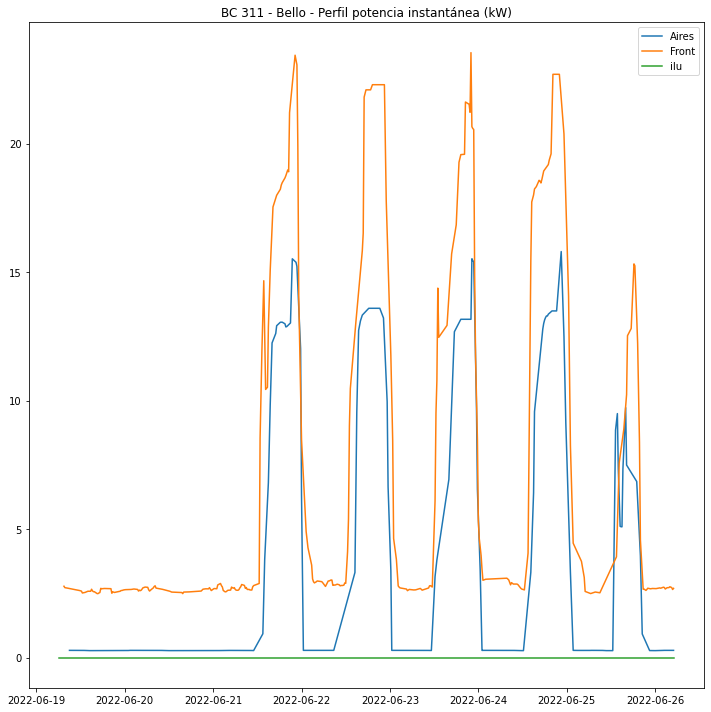

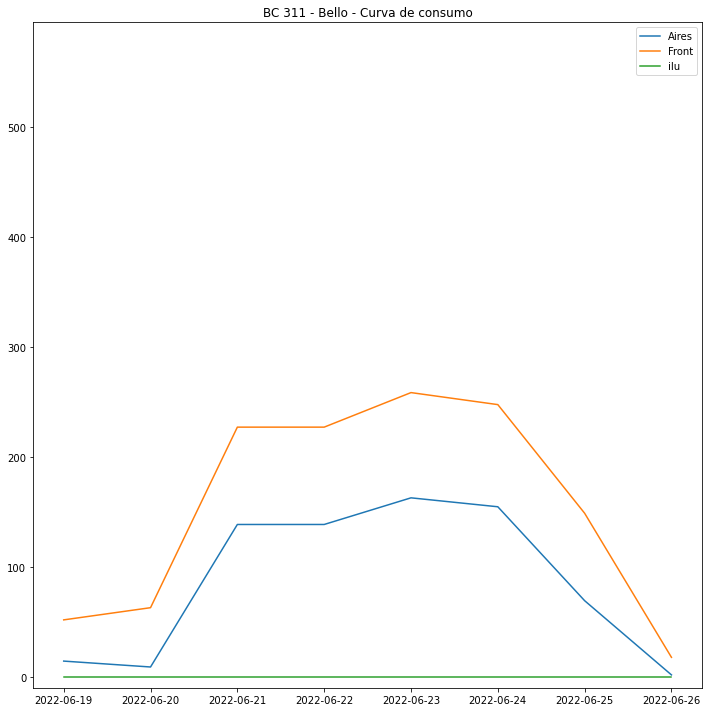

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        51.76        14.280          0.0            37.480  
2022-06-20 00:00:00        62.84         8.920          0.0            53.920  
2022-06-21 00:00:00       227.00       138.500          0.0            88.500  
2022-06-22 00:00:00       227.00       138.500          0.0            88.500  
2022-06-23 00:00:00       258.41       162.720          0.0            95.690  
2022-06-24 00:00:00       247.48       154.600          0.0            92.880  
2022-06-25 00:00:00       148.71        69.210          0.0            79.500  
2022-06-26 00:00:00        17.70         1.730          0.0            15.970  
Total                    1240.90       688.460          0.0           552.440  
%                         100.00        55.481          0.0            44.519  


In [21]:


device_label = devices["label"][15]
device_name = devices["device_name"][15]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Sin hallazgos de relevancia

## BC 185 - Llano Grande Palmira

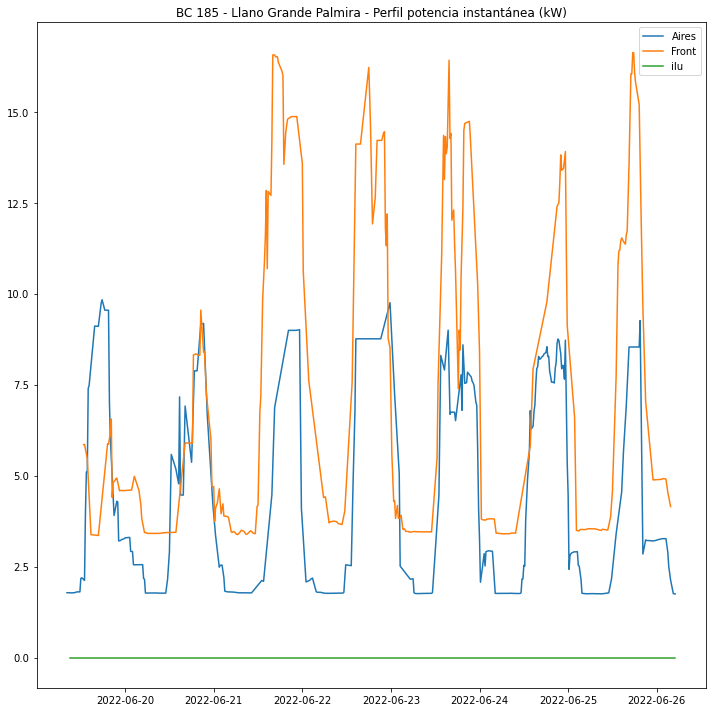

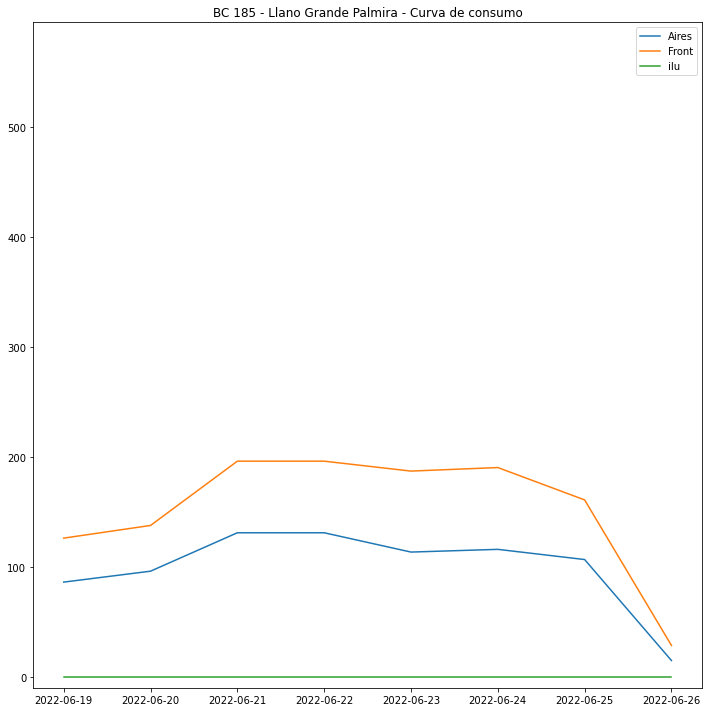

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       126.09        86.100          0.0            39.990  
2022-06-20 00:00:00       137.61        96.030          0.0            41.580  
2022-06-21 00:00:00       196.05       130.960          0.0            65.090  
2022-06-22 00:00:00       196.05       130.960          0.0            65.090  
2022-06-23 00:00:00       187.04       113.410          0.0            73.630  
2022-06-24 00:00:00       190.26       115.880          0.0            74.380  
2022-06-25 00:00:00       160.83       106.620          0.0            54.210  
2022-06-26 00:00:00        28.53        14.800          0.0            13.730  
Total                    1222.46       794.760          0.0           427.700  
%                         100.00        65.013          0.0            34.987  


In [22]:


device_label = devices["label"][16]
device_name = devices["device_name"][16]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo de Aire acondicionado constante incluso durante fines de semana, especialmente durante el fin de semana del 20 de junio ~ 90 kWh por día.

* Circuito de Aire se mantiene encendido durante el 24, 25 y 26 de junio hasta las 9:30 PM aproximadamente

## BC 88 - Cúcuta

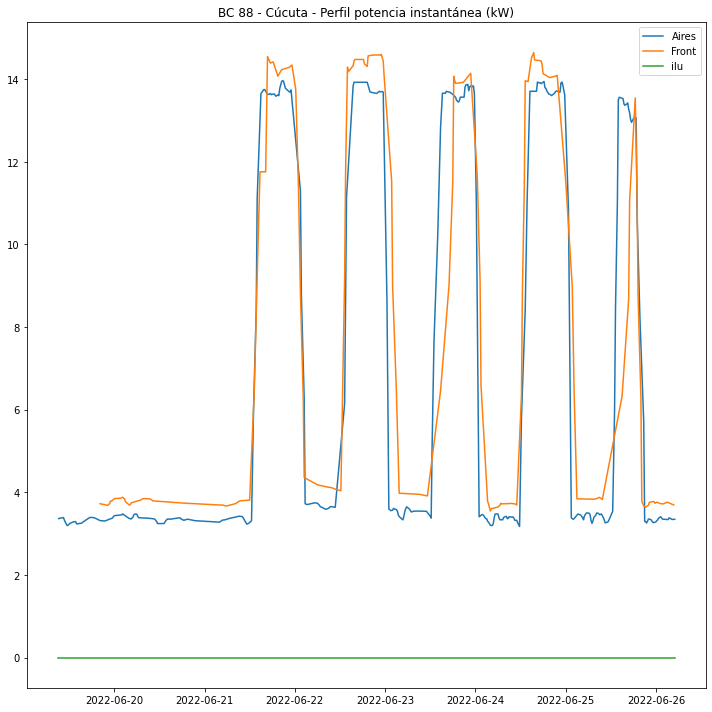

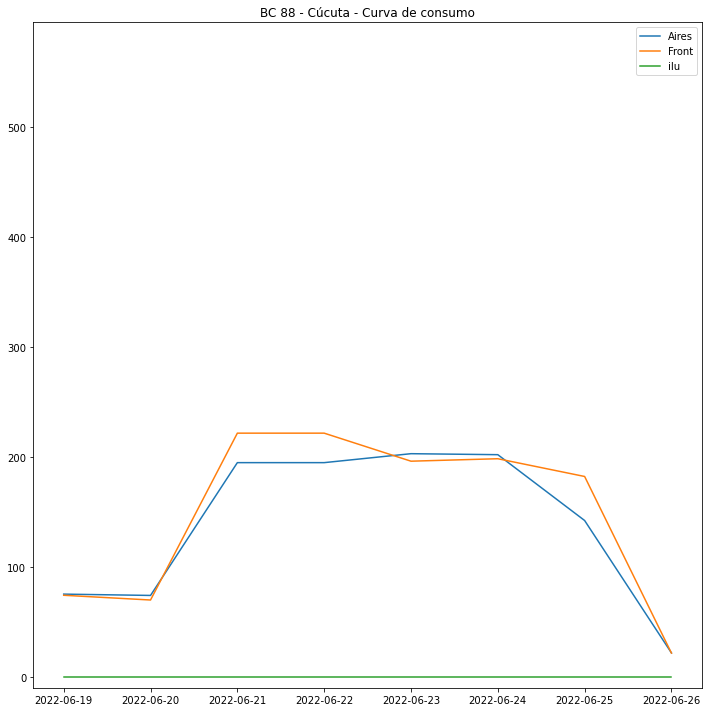

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        74.13        75.170          0.0           -1.040   
2022-06-20 00:00:00        69.82        73.980          0.0           -4.160   
2022-06-21 00:00:00       221.53       194.720          0.0           26.810   
2022-06-22 00:00:00       221.53       194.720          0.0           26.810   
2022-06-23 00:00:00       196.04       202.860          0.0           -6.820   
2022-06-24 00:00:00       198.28       201.960          0.0           -3.680   
2022-06-25 00:00:00       182.14       142.100          0.0           40.040   
2022-06-26 00:00:00        21.56        21.710          0.0           -0.150   
Total                    1185.03      1107.220          0.0           77.810   
%                         100.00        93.434          0.0            6.566   


In [23]:


device_label = devices["label"][17]
device_name = devices["device_name"][17]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Sin hallazgos de relevancia, consumo de Aire acondicionado representa aproximadamente el 93% del consumo total
* Consumo de aire durante las noches y fines de semana ~ 12 kWh 

## BC 197 - Guatapuri

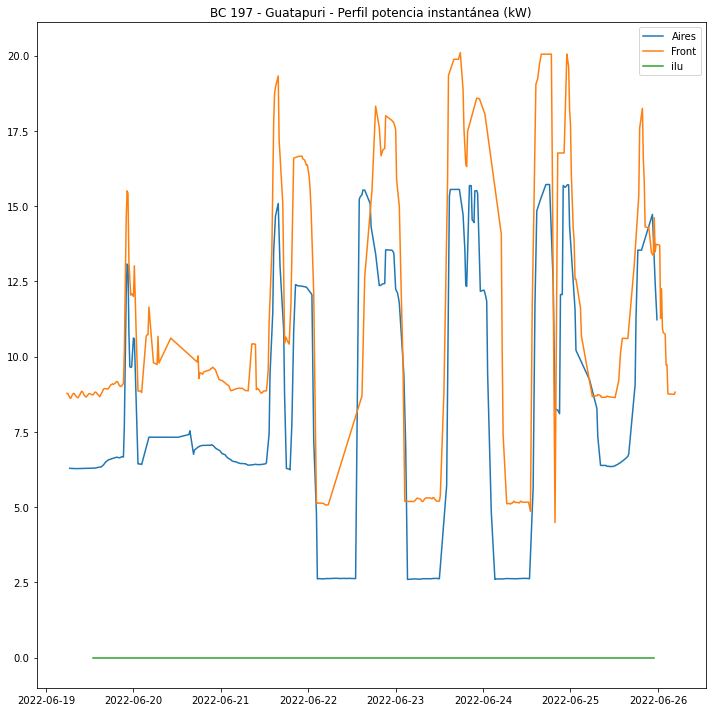

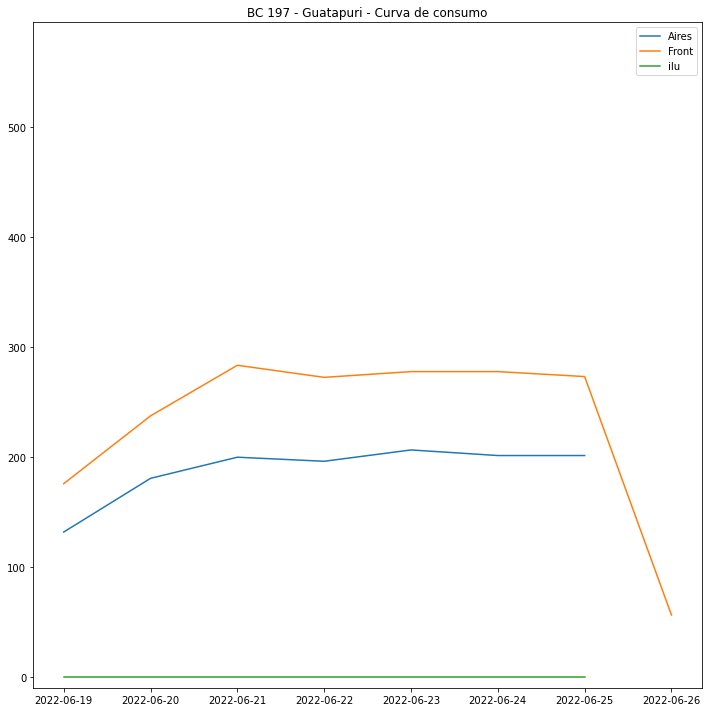

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       175.59        131.62          0.0            43.97   
2022-06-20 00:00:00       237.24        180.45          0.0            56.79   
2022-06-21 00:00:00       283.25        199.66          0.0            83.59   
2022-06-22 00:00:00       272.26        195.97          0.0            76.29   
2022-06-23 00:00:00       277.50        206.26          0.0            71.24   
2022-06-24 00:00:00       277.50        201.19          0.0            76.31   
2022-06-25 00:00:00       272.98        201.19          0.0            71.79   
Total                    1796.32       1316.34          0.0           479.98   
%                         100.00         73.28          0.0            26.72   


In [25]:

device_label = devices["label"][18]
device_name = devices["device_name"][18]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo de aire nocturnos y fines de semana ~ 24 kWh que suman más de 100 kWh durante los fines de semana

## BC 78 - El Cacique

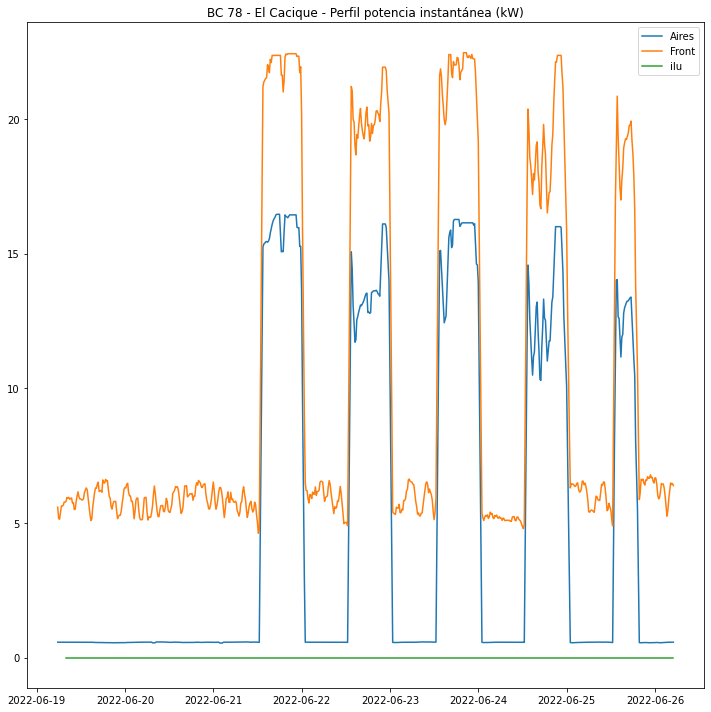

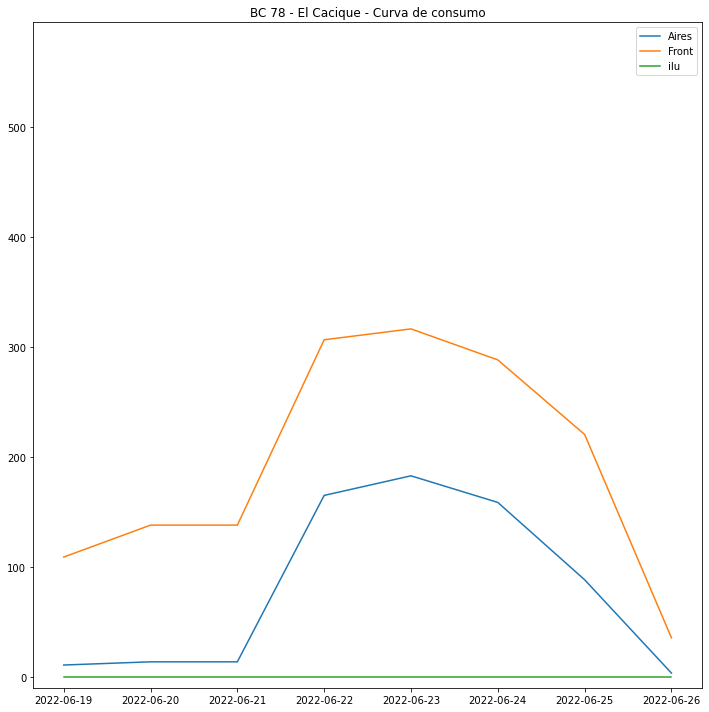

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00       108.88        10.710          0.0            98.170  
2022-06-20 00:00:00       137.91        13.620          0.0           124.290  
2022-06-21 00:00:00       137.91        13.620          0.0           124.290  
2022-06-22 00:00:00       306.44       164.930          0.0           141.510  
2022-06-23 00:00:00       316.34       182.740          0.0           133.600  
2022-06-24 00:00:00       288.13       158.550          0.0           129.580  
2022-06-25 00:00:00       220.34        88.230          0.0           132.110  
2022-06-26 00:00:00        35.45         3.380          0.0            32.070  
Total                    1551.40       635.780          0.0           915.620  
%                         100.00        40.981          0.0            59.019  


In [26]:

device_label = devices["label"][19]
device_name = devices["device_name"][19]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Sin hallazgos de relevancia

## BC 659 - Girardot

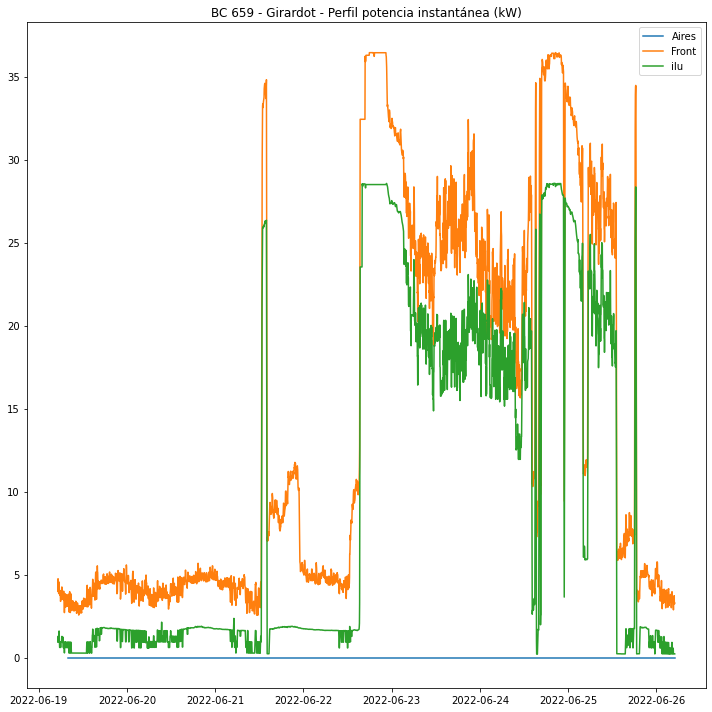

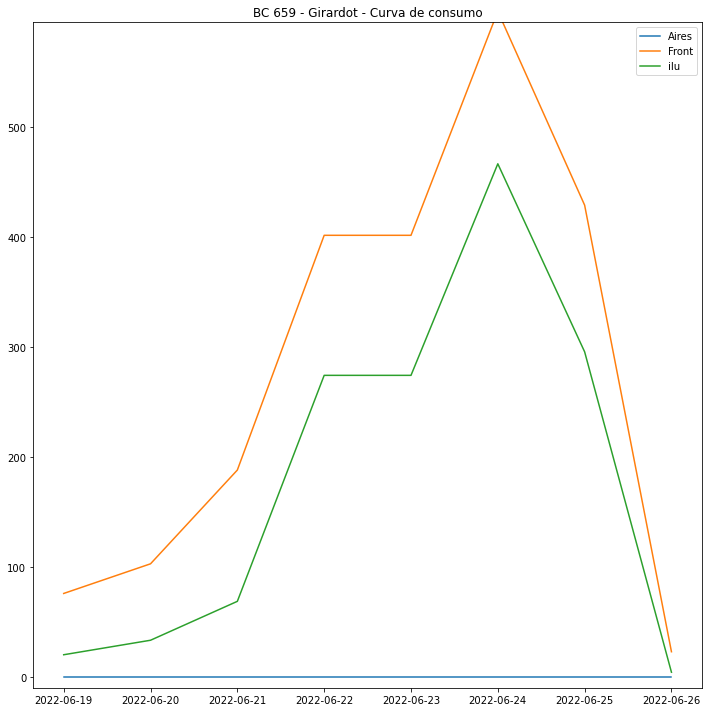

                     Frontera (kWh)  HVAC (kWh)  Iluminación (kWh)  Otros (kWh)
timestamp                                                                      
2022-06-19 00:00:00        75.78         0.0           20.060          55.720  
2022-06-20 00:00:00       102.74         0.0           33.240          69.500  
2022-06-21 00:00:00       188.00         0.0           68.620         119.380  
2022-06-22 00:00:00       401.42         0.0          274.090         127.330  
2022-06-23 00:00:00       401.42         0.0          274.090         127.330  
2022-06-24 00:00:00       605.04         0.0          466.440         138.600  
2022-06-25 00:00:00       428.83         0.0          295.470         133.360  
2022-06-26 00:00:00        22.79         0.0            4.150          18.640  
Total                    2226.02         0.0         1436.160         789.860  
%                         100.00         0.0           64.517          35.483  


In [27]:


device_label = devices["label"][20]
device_name = devices["device_name"][20]


variable_label = 'aa-potencia-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.rolling(4).mean()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-potencia-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.rolling(4).mean()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-potencia-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.rolling(4).mean()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')


plt.figure(figsize=(10,10))
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Perfil potencia instantánea (kW)")
plt.legend()
plt.tight_layout()



variable_label = 'aa-consumo-activa'
aa =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
aa = aa.resample("1D").sum()
aa =  aa[aa <= aa.quantile(0.95)] 
aa =aa.fillna(method='ffill')

variable_label = 'front-consumo-activa'
front =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
front = front.resample("1D").sum()
front =  front[front <= front.quantile(0.95)] 
front = front.fillna(method='ffill')

variable_label = 'ilu-consumo-activa'
ilu =  Ubidots.Download_from_ubidots(device_label,variable_label,datarange,timestamp_format, token)
ilu = ilu.resample("1D").sum()
ilu =  ilu[ilu <= ilu.quantile(0.95)] 
ilu = ilu.fillna(method='ffill')

consumo = pd.concat([front,aa,ilu],axis=1,join='inner')
consumo["Otros (kWh)"] = consumo["front-consumo-activa"] - consumo["aa-consumo-activa"] - consumo["ilu-consumo-activa"]
consumo.loc['Total'] = consumo.sum(numeric_only=True)
consumo.rename(columns = {'front-consumo-activa':'Frontera (kWh)', 'aa-consumo-activa':'HVAC (kWh)', 'ilu-consumo-activa':'Iluminación (kWh)'},inplace = True)

a = (consumo.div(consumo["Frontera (kWh)"]["Total"])[-1:]*100).rename(index={"Total": "%"})
consumo =consumo.append(a)



plt.figure(figsize=(10,10))
plt.ylim(-10, 595)
plt.plot(aa, label = "Aires")
plt.plot(front, label = "Front")
plt.plot(ilu, label = "ilu")
plt.title(f"{device_name} - Curva de consumo")

plt.tight_layout()
plt.legend()

plt.show()

print(consumo)

### **Hallazgos**:

* Consumo errático durante toda la semana, lo cual representó un incremento de consumo en más de 60%